In [1]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install fastapi

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ----------------------

In [5]:
!pip install uvicorn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install requests

Defaulting to user installation because normal site-packages is not writeable


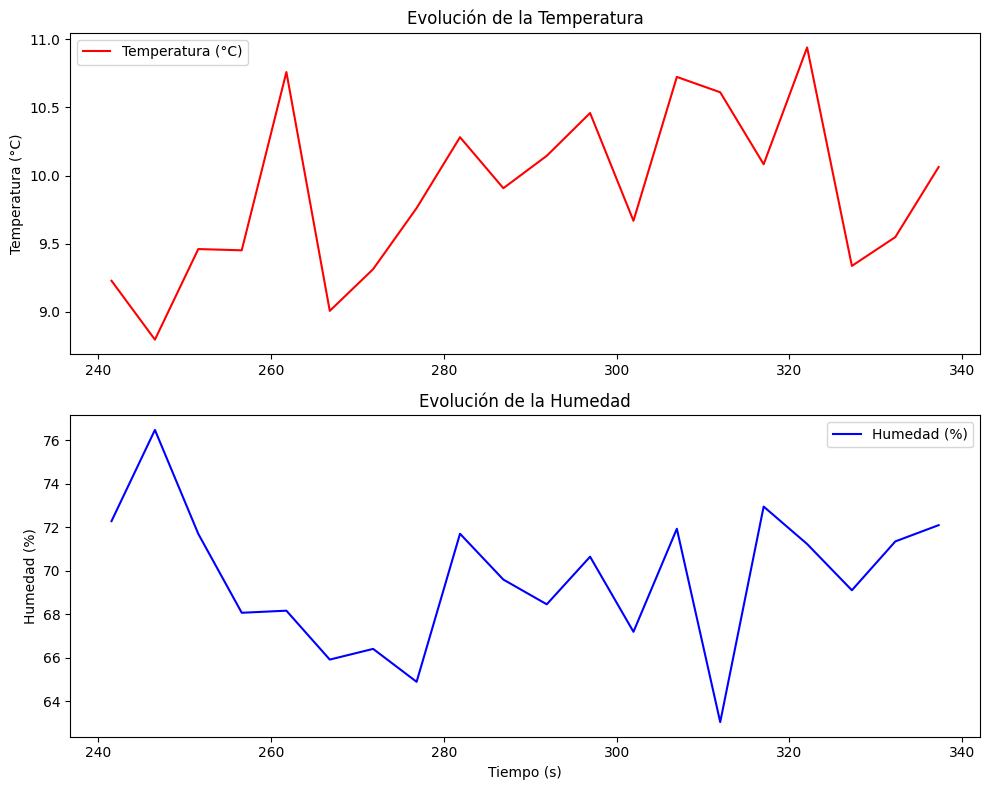

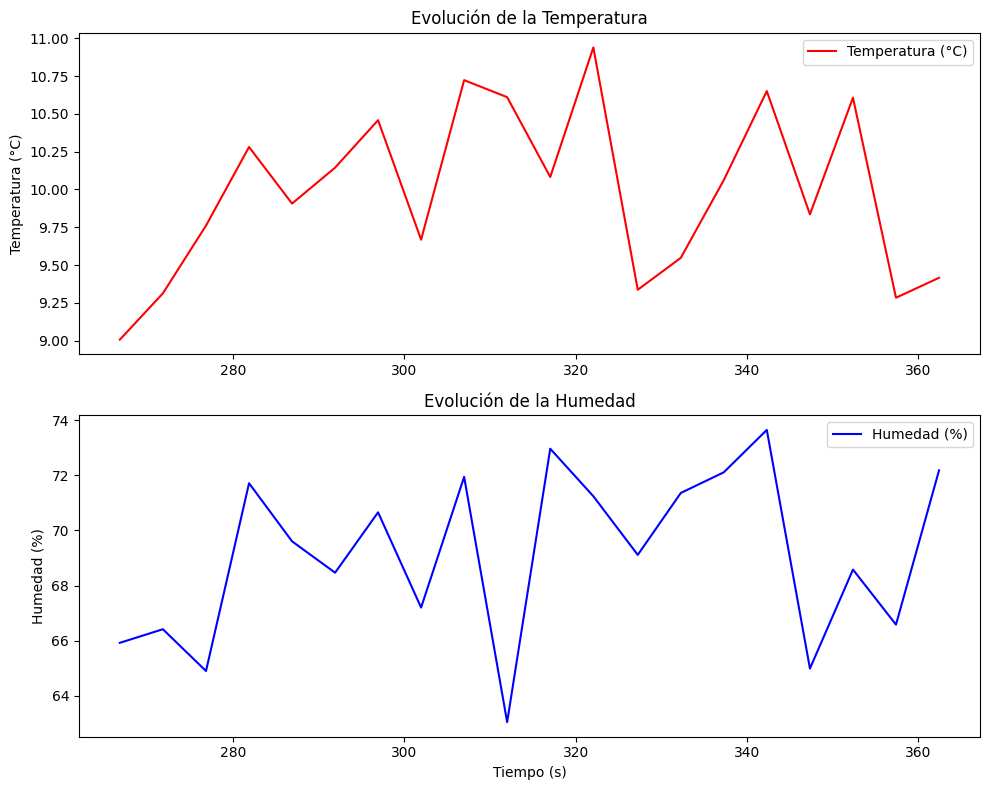

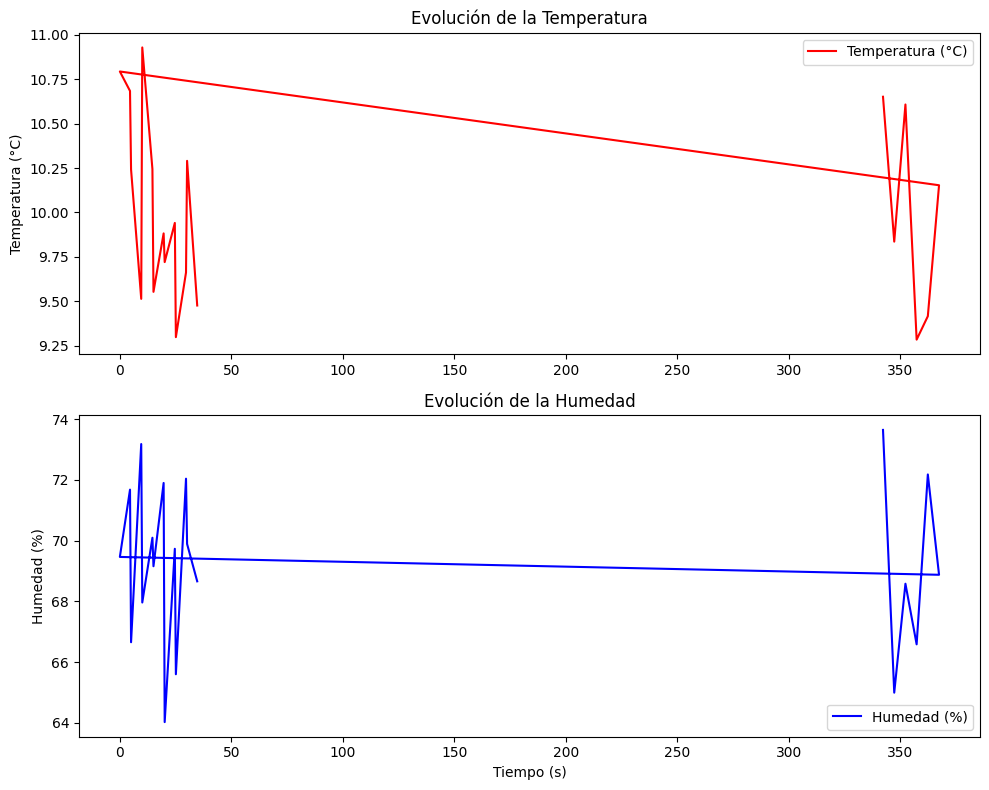

Error de conexión: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /guardar_datos (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001EC1C504320>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))
Error de conexión: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /guardar_datos (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001EC20FA0980>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))
Error de conexión: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /guardar_datos (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001EC20FA2B70>: Failed to establish a new connection: [WinError 10061

In [8]:
import tkinter as tk
from tkinter import ttk
import random
import time
import requests
import matplotlib.pyplot as plt

# Parámetros iniciales
NUM_SENSORES = 24
API_URL = "http://127.0.0.1:8000/guardar_datos"
CONFIG_URL = "http://127.0.0.1:8000/configuracion"

# Crear la ventana principal de Tkinter
root = tk.Tk()
root.title("Simulación de Terreno con Sensores")

# Canvas para el terreno
canvas = tk.Canvas(root, width=800, height=600, bg='green')
canvas.pack()

# Parámetros de distribución
filas = 4
columnas = 6
espacio_x = 150
espacio_y = 150
offset_x = 100
offset_y = 100

# Crear sensores y ubicarlos en una cuadrícula
sensores = []
for i in range(filas):
    for j in range(columnas):
        x = offset_x + j * espacio_x
        y = offset_y + i * espacio_y
        sensor = canvas.create_oval(x-10, y-10, x+10, y+10, fill='red')
        sensores.append((sensor, x, y))

# Configuración inicial
def obtener_configuracion():
    try:
        response = requests.get(CONFIG_URL)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error al obtener configuración: {response.text}")
    except Exception as e:
        print(f"Error de conexión: {e}")
    return {"temp_min": 7.0, "temp_max": 7.5, "humedad_min": 60, "humedad_max": 80}

config = obtener_configuracion()

# Función para generar datos del sensor
def obtener_datos_sensor():
    return [(i + 1, f"Sensor {i + 1}", random.uniform(5, 15), random.uniform(40, 100)) for i in range(NUM_SENSORES)]

# Función para enviar datos a FastAPI
def enviar_datos_a_api(temperaturas, humedades, tiempos):
    payload = [{"id": i + 1, 
                "nombre": f"Sensor {i + 1}", 
                "temperatura": temp, 
                "humedad": hum,
                "tiempo": tiempos[i] } 
               for i, (temp, hum) in enumerate(zip(temperaturas, humedades))]
    try:
        response = requests.post(API_URL, json=payload)
        if response.status_code != 200:
            print(f"Error al enviar datos: {response.text}")
    except Exception as e:
        print(f"Error de conexión: {e}")

# Función para abrir las gráficas
def mostrar_graficas():
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(historia_tiempos, historia_temperaturas, label="Temperatura (°C)", color="red")
    plt.title("Evolución de la Temperatura")
    plt.ylabel("Temperatura (°C)")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(historia_tiempos, historia_humedades, label="Humedad (%)", color="blue")
    plt.title("Evolución de la Humedad")
    plt.ylabel("Humedad (%)")
    plt.xlabel("Tiempo (s)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Función para actualizar el terreno y enviar datos a la API
def actualizar_terreno():
    global inicio

    # Obtener datos simulados
    datos = obtener_datos_sensor()
    temperaturas, humedades = zip(*[(data[2], data[3]) for data in datos])
    tiempos = [time.time() - inicio for _ in range(NUM_SENSORES)]  # Generar los tiempos

    # Actualizar el canvas
    canvas.delete("texto")
    for i, (sensor, x, y) in enumerate(sensores):
        temperatura = temperaturas[i]
        humedad = humedades[i]

        nuevo_color = 'orange' if (temperatura < config['temp_min'] or temperatura > config['temp_max']) else 'red'
        if canvas.itemcget(sensor, 'fill') != nuevo_color:
            canvas.itemconfig(sensor, fill=nuevo_color)

        canvas.create_text(x, y + 20, text=f"Temp: {temperatura:.1f}°C\nHum: {humedad:.1f}%", fill='black', tags="texto", font=('Helvetica', 10, 'bold'))

    # Guardar en la historia
    historia_temperaturas.append(sum(temperaturas) / len(temperaturas))
    historia_humedades.append(sum(humedades) / len(humedades))
    historia_tiempos.append(tiempos[0])

    # Limitar el historial
    if len(historia_temperaturas) > 20:
        historia_temperaturas.pop(0)
        historia_humedades.pop(0)
        historia_tiempos.pop(0)

    # Enviar datos a la API (ahora incluyendo la lista de tiempos)
    enviar_datos_a_api(temperaturas, humedades, tiempos)

    # Programar la actualización del terreno cada 5 segundos
    root.after(5000, actualizar_terreno)

# Variables globales
historia_temperaturas = []
historia_humedades = []
historia_tiempos = []

inicio = time.time()

# Función para iniciar la simulación
def iniciar_simulacion():
    global inicio
    inicio = time.time()
    actualizar_terreno()

# Función para detener la simulación
def detener_simulacion():
    global inicio
    inicio = None

# Crear los botones de control
boton_iniciar = ttk.Button(root, text="Iniciar Simulación", command=iniciar_simulacion)
boton_detener = ttk.Button(root, text="Detener Simulación", command=detener_simulacion)
boton_graficas = ttk.Button(root, text="Mostrar Gráficas", command=mostrar_graficas)

boton_iniciar.pack()
boton_detener.pack()
boton_graficas.pack()

# Iniciar el loop de Tkinter
root.mainloop()


